<a target="_blank" href="https://colab.research.google.com/github/kircherlab/ISMB-2025_IGVF-MPRA-Tutorial/blob/main/05_sequence_models/02_ism_and_tfmodisco.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Interpreting Models with In-Silico Mutagenesis

With tools like TF-MoDISco for motif discovery, we will investigate important transcription factor binding motifs using models trained on sequence data that predict activity. We will assess whether these motifs exert activating or repressing effects by comparing the activity of sequences with and without these identified motifs in the cell type of interest.

## Notebook Preparation

### Load Libraries and Data

In [1]:
import os
import random
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from IPython.display import clear_output

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppress TensorFlow warnings

2025-05-15 12:46:17.509982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-15 12:46:17.720500: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
!pip install modisco-lite

Download the data if not already present.

In [3]:
%%bash
mkdir -p 02_data

if [ ! -f "02_data/ultra_joint.fa.gz" ]; then
    wget -O 02_data/ultra_joint.fa.gz https://github.com/kircherlab/ISMB-2025_IGVF-MPRA-Tutorial/raw/refs/heads/main/05_sequence_models/02_data/ultra_joint.fa.gz
else
    echo "File exists"
fi

File exists


### Prepare Sequences from FASTA for DNN Model

Set seeds to make code reproducible. This is always a good idea when working with TensorFlow. The seed of 42 is arbitraty.

In [4]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Load sequences for which we want to generate contribution maps. Print one example entry. The sequences are in FASTA format. Each entry contains two lines: the first is the sequence ID, the second is the sequence. Note that we have removed the ">" from the output printed below.

In [5]:
seq_file = "02_data/ultra_joint.fa.gz"

with gzip.open(seq_file, 'rt') as f:
    file_content = f.read()

sequence_entries = file_content.split('>')

print(sequence_entries[3])

HepG2_DNasePeakNoPromoter42110
AGGACCGGATCAACTTTTGGGAGAAAGAGGGTGTGAAGAGATGGCTCTGCGTCCTAAGCGAAGGTAAGCAACCTCATGAACATGGCTCTGGACGCTGGAGGCCCTGGTCCCTGGACTTTGGGCTTGGAAGCAAAGGCCACTGACTGTTTCTCTATCACTCTGAGAAGCTCCATTGTGCCTGGGCCTCTTAGATGATTATTTTATAAACTATGGATCATTGCGTGAACCGA



Write IDs and sequences into Python lists.

In [6]:
sequence_ids = []
sequences = []

for i in range(1, len(sequence_entries)):
    entry = sequence_entries[i]
    if "\n" not in entry:
        print(entry)
        raise ValueError("Entry missing newline between ID and sequence.")
    seq = entry.split("\n")[1]
    if "Y" in seq or "R" in seq:
        continue
    sequence_ids.append(entry.split("\n")[0])
    sequences.append(seq)

# Show sequence number 10 as an example
print("ID list entry example:", sequence_ids[9])
print("Sequence list entry example:", sequences[9])

ID list entry example: HepG2_DNasePeakNoPromoter27047
Sequence list entry example: AGGACCGGATCAACTATTTATAACTTCCCCAAAGGTCCAAAGAACTTTTTTGGATGTTTTGTACTGGAGTTGGTCTTGAGTTTCTGCACATGTGATACACTAGGTGGTGCTAATTGACTGAGCTGAGCAGGGACACTCTTTGCAGCGACGTTAAAGACTAAACCTCACTGAATAGATGTTTTTACAGACGTCAATCAAAGGAGGAAATCTCAATTCATTGCGTGAACCGA


To pass the sequences to our model, we need to "one-hot encode" them. We'll load the necessary function.

In [7]:
def one_hot_encode(seq):
    nucleotide_dict = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'N': [0, 0, 0, 0]
    }
    return np.array([nucleotide_dict[nuc] for nuc in seq])

Apply one-hot encoding to our sequences. The output demonstrates how one-hot encoding looks.

In [8]:
sequences_tok = [one_hot_encode(seq) for seq in sequences]

print("Sequence list entry example (first 5 bases):\n", sequences[9][:5])
print("Sequence list entry example one-hot encoded (first 5 bases):\n", sequences_tok[9][:5])

Sequence list entry example (first 5 bases):
 AGGAC
Sequence list entry example one-hot encoded (first 5 bases):
 [[1 0 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]]


Convert the lists into a pandas DataFrame. This helps with removing duplicates and inspecting the data.

In [9]:
df_IDs_seq = pd.DataFrame({
    "ID": sequence_ids,
    "seq": sequences_tok,
    "seq_org": sequences
})

df_IDs_seq = df_IDs_seq.drop_duplicates(subset="ID")

print("The ID column of the dataframe:\n", df_IDs_seq["ID"])
print("\nThe original sequence column of the dataframe:\n", df_IDs_seq["seq_org"])
print("\nThe one-hot encoded sequence column of the dataframe:\n", df_IDs_seq["seq"])

The ID column of the dataframe:
 0        HepG2_DNasePeakNoPromoter38956
1        HepG2_DNasePeakNoPromoter53608
2        HepG2_DNasePeakNoPromoter42110
3        HepG2_DNasePeakNoPromoter24309
4        HepG2_DNasePeakNoPromoter46096
                      ...              
59995                   ENSG00000137409
59996                   ENSG00000187601
59997                   ENSG00000175216
59998                   ENSG00000100865
59999                   ENSG00000170889
Name: ID, Length: 60000, dtype: object

The original sequence column of the dataframe:
 0        AGGACCGGATCAACTATCAATTACACCACTGGAGGCTCCTGGCTGC...
1        AGGACCGGATCAACTCCTTGGCAGGCTTGCCCATGACGAATCCCCG...
2        AGGACCGGATCAACTTTTGGGAGAAAGAGGGTGTGAAGAGATGGCT...
3        AGGACCGGATCAACTTTCTCCCTGCCCTTCCCTCAAAGTGTCAGTC...
4        AGGACCGGATCAACTGGGGCCCTTGGGAACTCCATGCCCTGACTAT...
                               ...                        
59995    AGGACCGGATCAACTCGGGGAGCCACATCCGGCGTGTCCCACCCGC...
59996    AGGACCGGATCAACTGC

Convert the one-hot encoded sequences to TensorFlow tensors for input to our pre-trained model.

In [10]:
input_seq_all = tf.convert_to_tensor(df_IDs_seq["seq"].to_list())

### Load Model

Load our pretrained model. Here, we use the MPRAnn architecture trained on sequences and experimental MPRA activity from the MPRAultra study (K562 dataset). Ensure your data matches the model's expected sequence length.

In [11]:
%%bash
mkdir -p 02_data

if [ ! -f "02_data/MPRAnn.h5" ]; then
    wget -O 02_data/MPRAnn.h5 https://github.com/kircherlab/ISMB-2025_IGVF-MPRA-Tutorial/raw/refs/heads/main/05_sequence_models/02_data/MPRAnn.h5
else
    echo "File exists"
fi

File exists


In [12]:
model = keras.models.load_model("02_data/MPRAnn.h5")

## Model Interpretation Using Attribution Maps and TF-MoDISco

### Sequences

We will initialize numpy arrays to store the attribution maps of the sequences based on our pre-trained model, as well as the one-hot encoded sequences. Both are required inputs for TF-MoDISco. For demonstration, we only process a subset of sequences to keep computation feasible.

## Sequences for TF-MoDISco

In [13]:
numberOfSeqs = np.asarray(input_seq_all).shape[0] // 6000  # Use a subset for speed
seq_length = np.asarray(input_seq_all).shape[1]

seqs_tfmodisco_format = np.zeros([numberOfSeqs, seq_length, 4], dtype=bool)
for i in range(numberOfSeqs):
    seqs_tfmodisco_format[i] = input_seq_all[i].numpy().astype(bool)

np.savez('02_data/Sequences.npz', seqs_tfmodisco_format)

Load the one-hot encoded sequences and inspect them. The array shape matches the contribution score array. Data type is bool.

In [14]:
print(seqs_tfmodisco_format)

[[[ True False False False]
  [False False  True False]
  [False False  True False]
  ...
  [False  True False False]
  [False False  True False]
  [ True False False False]]

 [[ True False False False]
  [False False  True False]
  [False False  True False]
  ...
  [False  True False False]
  [False False  True False]
  [ True False False False]]

 [[ True False False False]
  [False False  True False]
  [False False  True False]
  ...
  [False  True False False]
  [False False  True False]
  [ True False False False]]

 ...

 [[ True False False False]
  [False False  True False]
  [False False  True False]
  ...
  [False  True False False]
  [False False  True False]
  [ True False False False]]

 [[ True False False False]
  [False False  True False]
  [False False  True False]
  ...
  [False  True False False]
  [False False  True False]
  [ True False False False]]

 [[ True False False False]
  [False False  True False]
  [False False  True False]
  ...
  [False  True False Fal

In [15]:
seq_file = "02_data/Sequences.npz"
seqs = np.load(seq_file)
seqs = seqs.f.arr_0.astype(bool)

print(seqs[9])
print(seqs.shape)
print(seqs.dtype)

[[ True False False False]
 [False False  True False]
 [False False  True False]
 [ True False False False]
 [False  True False False]
 [False  True False False]
 [False False  True False]
 [False False  True False]
 [ True False False False]
 [False False False  True]
 [False  True False False]
 [ True False False False]
 [ True False False False]
 [False  True False False]
 [False False False  True]
 [ True False False False]
 [False False False  True]
 [False False False  True]
 [False False False  True]
 [ True False False False]
 [False False False  True]
 [ True False False False]
 [ True False False False]
 [False  True False False]
 [False False False  True]
 [False False False  True]
 [False  True False False]
 [False  True False False]
 [False  True False False]
 [False  True False False]
 [ True False False False]
 [ True False False False]
 [ True False False False]
 [False False  True False]
 [False False  True False]
 [False False False  True]
 [False  True False False]
 

### Attribution Scores

Now we compute the attribution (contribution) scores using in-silico mutagenesis (ISM). For each sequence, we generate all possible single-nucleotide variants (SNVs) and predict their activity using our model.

In [16]:
hypothetical_contribution_scores = np.zeros([numberOfSeqs, seq_length, 4])

for i in range(numberOfSeqs):
    print(f"{i+1} of {numberOfSeqs}")
    listOfMutSeqs = []
    for j in range(seq_length):
        temp_seq = input_seq_all[i].numpy().copy()
        temp_seq[j, :] = 0
        for k in range(4):
            temp_seq[j, k] = 1
            listOfMutSeqs.append(tf.convert_to_tensor(temp_seq.copy()))
            temp_seq[j, k] = 0
    tensorOfMutSeqs = tf.convert_to_tensor(listOfMutSeqs)
    predictions_alt = model.predict(tensorOfMutSeqs, batch_size=256, verbose=0)
    for j in range(seq_length):
        for k in range(4):
            hypothetical_contribution_scores[i, j, k] = predictions_alt[j*4+k, 0]

np.savez("02_data/hypothetical_contribution_scores.npz", hypothetical_contribution_scores)

1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
10 of 10


## Attribution Maps

This section introduces attribution maps. First, we load the file with the contribution scores generated above.

### Attribution Maps in General

Attribution maps highlight bases or motifs that are important for the model's prediction of a given sequence. Let's look at the contribution scores as calculated above:

In [17]:
contrib_file = "02_data/hypothetical_contribution_scores.npz"
scores = np.load(contrib_file)
scores = scores.f.arr_0.astype(np.float32)

A widely used approach is to subtract the prediction of the reference sequence from all predictions (see [Kelley et al.](https://pubmed.ncbi.nlm.nih.gov/27197224/)).

In [18]:
ref_seq = scores * seqs # Set everything to zero wat is not reference.

ref_pred = np.repeat(ref_seq[np.nonzero(ref_seq)].reshape(seqs.shape[0], seqs.shape[1])[..., np.newaxis], 4, axis=-1) # Select non-zero (reference) values and copy it to all 4 nucleotides.
scores = scores - ref_pred # Substract the reference prediction from all predictions.

Let's look at the attribution map of a single sequence. For each position, there are 4 entries (A, C, G, T). The value indicates the importance of the base at that position for the measured MPRA activity, based on the model. The array shape is (number of sequences, sequence length, 4).

In [19]:
print(scores.shape)
print(scores.dtype)
print(scores[9])

(10, 230, 4)
float32
[[ 0.00000000e+00 -6.44624233e-05 -4.20928001e-04  8.21024179e-04]
 [-7.22140074e-04 -3.13401222e-04  0.00000000e+00 -7.67588615e-04]
 [ 3.01599503e-04  3.60757113e-04  0.00000000e+00 -1.05324388e-03]
 [ 0.00000000e+00  1.87018514e-03  5.09977341e-04 -1.20741129e-03]
 [-1.60393119e-03  0.00000000e+00  7.08788633e-03 -1.48102641e-03]
 [-9.99221206e-03  0.00000000e+00 -2.29123235e-03  2.99116969e-03]
 [ 8.54676962e-03  3.73718143e-03  0.00000000e+00  1.25913620e-02]
 [-2.76681781e-03  1.75780058e-03  0.00000000e+00  1.69725716e-02]
 [ 0.00000000e+00 -1.18434429e-04  8.79737735e-03 -3.86536121e-04]
 [ 2.47034431e-03  1.02202296e-02  5.41955233e-03  0.00000000e+00]
 [ 1.42753124e-02  0.00000000e+00  7.91740417e-03 -8.37862492e-03]
 [ 0.00000000e+00 -3.79893184e-03  2.49603987e-02  9.81682539e-03]
 [ 0.00000000e+00  1.99653506e-02  1.45809948e-02 -5.61189651e-03]
 [-1.21884644e-02  0.00000000e+00  6.19655848e-03 -3.82485688e-02]
 [ 5.25024533e-03  1.45725906e-02 -7.9357

We now use the logomaker library to plot a selected attribution map (here, the 10th sequence). Importantness is expressed by scaling the bases according to the maximal possible prediction loss.

In [20]:
scores_for_map = np.abs(scores - np.min(scores, axis=2, keepdims=True))
scores_for_map *= seqs

df_hypo_contri = pd.DataFrame(scores_for_map[9], columns=['A', 'C', 'G', 'T'])
print(df_hypo_contri)

            A         C         G    T
0    0.000421  0.000000  0.000000  0.0
1    0.000000  0.000000  0.000768  0.0
2    0.000000  0.000000  0.001053  0.0
3    0.001207  0.000000  0.000000  0.0
4    0.000000  0.001604  0.000000  0.0
..        ...       ...       ...  ...
225  0.000000  0.000000  0.000000  0.0
226  0.000000  0.009221  0.000000  0.0
227  0.000000  0.000000  0.000000  0.0
228  0.000000  0.000000  0.000019  0.0
229  0.000000  0.000000  0.000000  0.0

[230 rows x 4 columns]


In [21]:
%matplotlib inline

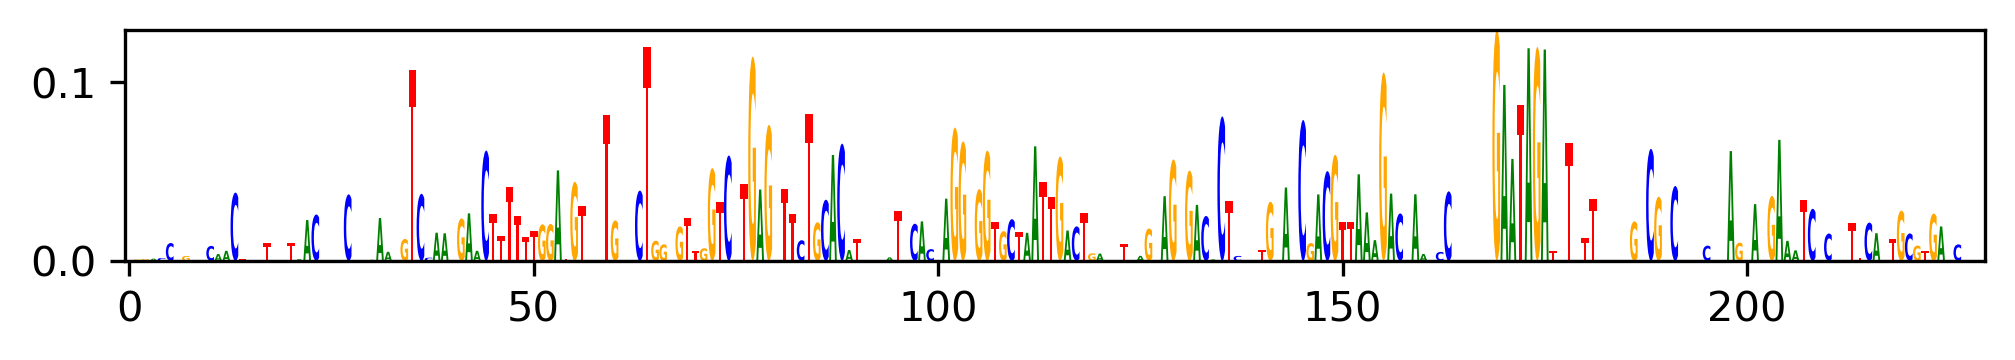

In [22]:
import logomaker

fig = plt.figure(figsize=(8, 1), dpi=300)
ax1 = fig.add_subplot(111)
PWM_logo = logomaker.Logo(df_hypo_contri, shade_below=.5, fade_below=.5, ax=ax1)
plt.savefig("02_data/example_contrib_map.png", dpi=300)
plt.show()

### Attribution Maps for TF-MoDISco

For TF-MoDISco, it is recommended to mean-normalize the contribution scores (see [TF-MoDISco example](https://github.com/kundajelab/tfmodisco/blob/master/examples/simulated_TAL_GATA_deeplearning/Generate%20Importance%20Scores.ipynb)).

In [23]:
scores_for_modisco = scores - np.mean(scores, axis=2, keepdims=True)
np.savez("02_data/scores_for_modisco.npz", hypothetical_contribution_scores)

Let's plot the mean-normalized hypothetical scores used for TF-MoDISco:

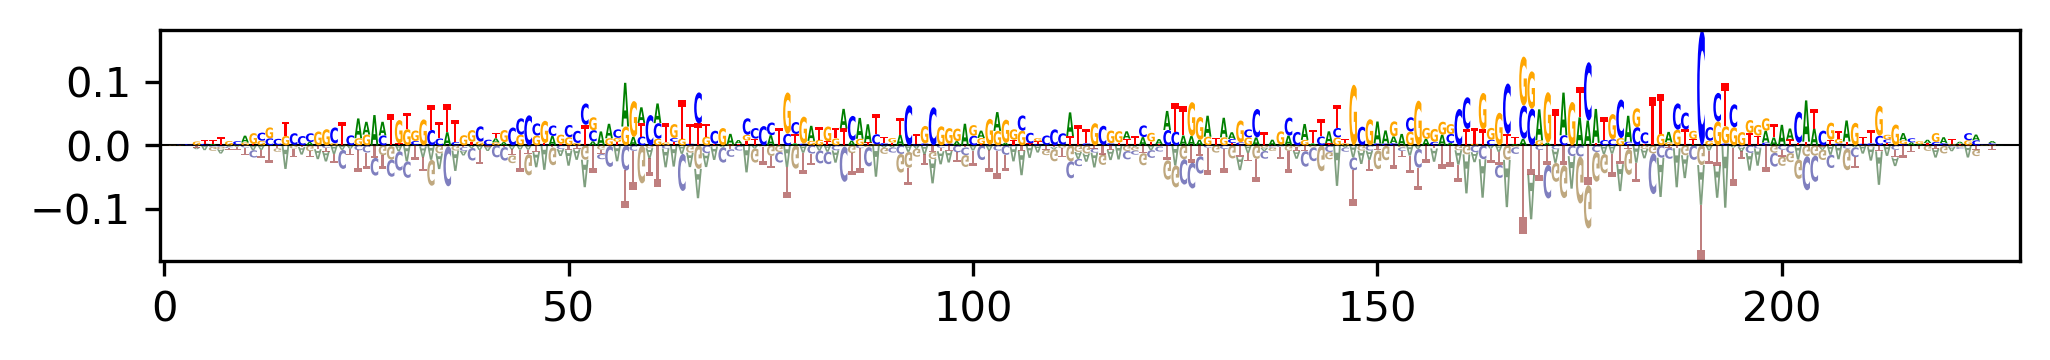

In [24]:
df_hypo_contri = pd.DataFrame(scores_for_modisco[9], columns=['A', 'C', 'G', 'T'])
fig = plt.figure(figsize=(8, 1), dpi=300)
ax1 = fig.add_subplot(111)
PWM_logo = logomaker.Logo(df_hypo_contri, shade_below=.5, fade_below=.5, ax=ax1)
plt.savefig("02_data/example_contrib_map.png", dpi=300)
plt.show()

And the actual contribution scores resulting from it:

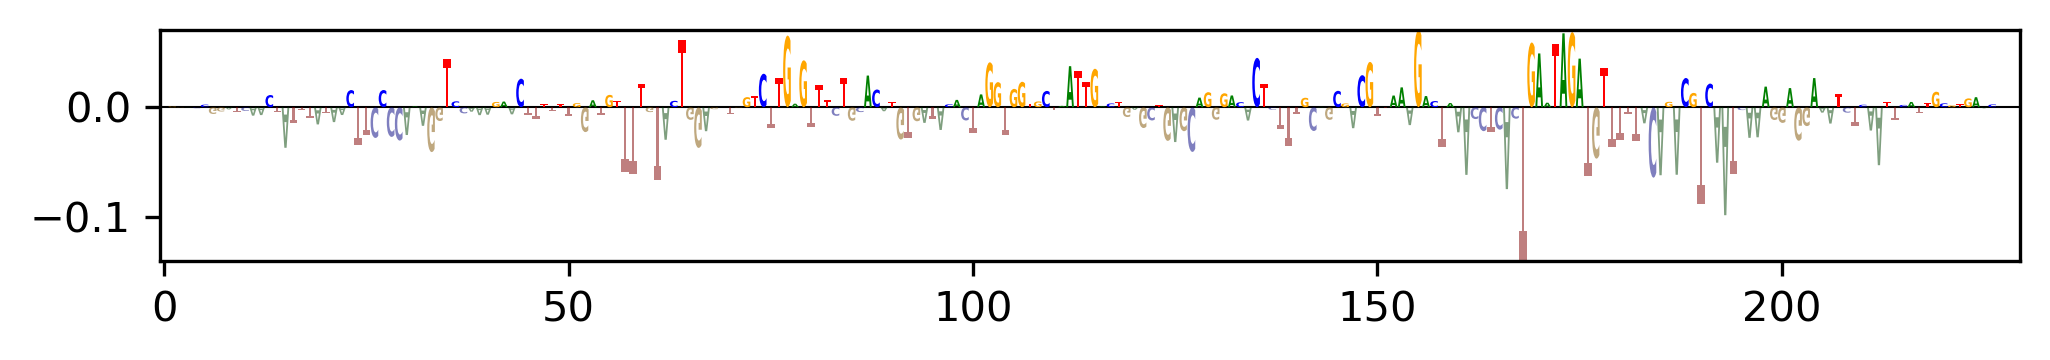

In [25]:
df_hypo_contri = pd.DataFrame(scores_for_modisco[9] * seqs[9], columns=['A', 'C', 'G', 'T'])
fig = plt.figure(figsize=(8, 1), dpi=300)
ax1 = fig.add_subplot(111)
PWM_logo = logomaker.Logo(df_hypo_contri, shade_below=.5, fade_below=.5, ax=ax1)
plt.savefig("02_data/example_contrib_map.png", dpi=300)
plt.show()

Note that both ways of plotting actual contribution scores result from the same data and include very similar information.

# Using TF-MoDISco

## Setting Up the Environment

Now we can set up the environment.

In [26]:
import modiscolite

## Running TF-MoDISco

Above, we learned how to interpret a model's representation of a given sequence. However, with tens of thousands of sequences, you don't want to look at each one individually. TF-MoDISco summarizes the model's representation across all sequences.

Now that we have prepared all the arrays for TF-MoDISco, we can run it. The result depends on the parameters you use. Here, we use only a subset of the data for speed.

In [27]:
pos_patterns, neg_patterns = modiscolite.tfmodisco.TFMoDISco(
    sliding_window_size=8,
    flank_size=8,
    min_metacluster_size=20,
    target_seqlet_fdr=0.1,
    hypothetical_contribs=scores_for_modisco,
    one_hot=seqs,
    max_seqlets_per_metacluster=20000,
    trim_to_window_size=10,
    n_leiden_runs=2,
    initial_flank_to_add=3,
    final_min_cluster_size=30,
    verbose=True
)

modiscolite.io.save_hdf5(contrib_file + ".h5", pos_patterns, neg_patterns, window_size=8)

print(pos_patterns)
print(neg_patterns)

None
None


Finally, we can run the command-line version of TF-MoDISco to generate an HTML report. The example below uses the full dataset. The JASPAR database is used for motif annotation.

In [28]:
%%bash
if [ ! -f "02_data/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme_nice.txt" ]; then
    wget -O 02_data/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme_nice.txt https://github.com/kircherlab/ISMB-2025_IGVF-MPRA-Tutorial/raw/refs/heads/main/05_sequence_models/02_data/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme_nice.txt
else
    echo "File exists"
fi

File exists


In [29]:
%%bash
modisco report \
-i 02_data/hypothetical_contribution_scores.npz.h5 \
-o 02_data/tfmodisco_report/ \
-s 02_data/tfmodisco_report/ \
-m 02_data/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme_nice.txt

After creating a copy of the file `motifs.html` in the directory above the output folder, we can explore the TF-MoDISco results. If your previous run has `None` positive and `None` negative pattern (which might be on small number of sequences withn this example), you will not see any pattern.

In [30]:
!cp 02_data/tfmodisco_report/motifs.html motifs.html
from IPython.display import HTML
HTML(filename='motifs.html')

pattern,num_seqlets,modisco_cwm_fwd,modisco_cwm_rev,match0,qval0,match0_logo,match1,qval1,match1_logo,match2,qval2,match2_logo


Finally we show you the TF-Modisco report on the complete sample on all sequences (not only 10). Please note that we were not able to show the sequence logos when you run this tutorial on Google Colab. You might download the files and folders (keep the foldor structure) to see the logos on your local machine.

In [31]:
%%bash
if [ ! -f "02_data/tfmodisco_report_all.tar.gz" ]; then
    wget -O 02_data/tfmodisco_report_all.tar.gz https://github.com/kircherlab/ISMB-2025_IGVF-MPRA-Tutorial/raw/refs/heads/main/05_sequence_models/02_data/tfmodisco_report_all.tar.gz
else
    echo "File exists"
fi

tar -xzf 02_data/tfmodisco_report_all.tar.gz -C 02_data/
sed -i 's/tfmodisco_report_MPRAultra_all\//02_data\/tfmodisco_report_all\//g' 02_data/tfmodisco_report_all/motifs.html 
cp 02_data/tfmodisco_report_all/motifs.html motifs_all.html

File exists


In [32]:
HTML(filename='motifs_all.html')

pattern,num_seqlets,modisco_cwm_fwd,modisco_cwm_rev,match0,qval0,match0_logo,match1,qval1,match1_logo,match2,qval2,match2_logo
pos_patterns.pattern_0,3592,,,MA0599.1_MA0599.1.KLF5,0.000020,,MA0685.2_MA0685.2.SP4,0.000020,,MA0079.5_MA0079.5.SP1,0.000026,
pos_patterns.pattern_1,2938,,,MA0474.3_MA0474.3.Erg,0.000051,,MA1956.1_MA1956.1.FOXO1::FLI1,0.000111,,MA0062.3_MA0062.3.GABPA,0.000111,
pos_patterns.pattern_2,1531,,,MA0036.3_MA0036.3.GATA2,0.001342,,MA1970.1_MA1970.1.TRPS1,0.001342,,MA1104.2_MA1104.2.GATA6,0.001342,
pos_patterns.pattern_3,1410,,,MA1644.1_MA1644.1.NFYC,0.000005,,MA0060.3_MA0060.3.NFYA,0.000100,,MA0502.2_MA0502.2.NFYB,0.055698,
pos_patterns.pattern_4,1298,,,MA1633.2_MA1633.2.BACH1,0.004738,,MA0835.2_MA0835.2.BATF3,0.004738,,MA1988.1_MA1988.1.Atf3,0.004738,
pos_patterns.pattern_5,1233,,,MA0643.1_MA0643.1.Esrrg,1.000000,,MA0160.2_MA0160.2.NR4A2,1.000000,,MA1581.1_MA1581.1.ZBTB6,1.000000,
pos_patterns.pattern_6,904,,,MA0833.2_MA0833.2.ATF4,0.000593,,MA1636.1_MA1636.1.CEBPG,0.001334,,MA1962.1_MA1962.1.POU2F1::SOX2,0.268047,
pos_patterns.pattern_7,507,,,MA1512.1_MA1512.1.KLF11,0.000483,,MA0746.2_MA0746.2.SP3,0.000516,,MA1517.1_MA1517.1.KLF6,0.000516,
pos_patterns.pattern_8,314,,,MA0093.3_MA0093.3.USF1,0.000019,,MA0831.3_MA0831.3.TFE3,0.000441,,MA0636.1_MA0636.1.BHLHE41,0.000441,
pos_patterns.pattern_9,285,,,MA0088.2_MA0088.2.ZNF143,1.000000,,MA1716.1_MA1716.1.ZNF76,1.000000,,MA0038.2_MA0038.2.GFI1,1.000000,
